# Automated Pollen grain Classification in Fossil Pollen using Deep Learning

In this document we share our process of extracting, purifying and augmenting our raw data into the published Dataset, as well as training and evaluating our Deep Learning approach.

### 0. Environment Setup

This jupyter-notebook document is used to replicate the work in our study (doi:), if you only want to test the model or show how it can be applied on other images use the file: test.ipynb that is located in the same directory as this document.

Before running the cells below, make sure that you have downloaded all required libraries (e.g., image dataset for training the object detection or classification model).

This project was created with the python version 3.8.10 and may be updated in the future for compatibility reasons. Additionally, please not that this project was done with Windows version 11 and the following code is supposed to work for computers that use Windows version 8 or above and successfully have installed a python version (https://www.python.org/downloads/) on the computer. Mac Os or Linux users may need to install the packages manually. Compatibility for other systems may be added in the future.

I suggest using VisualStudioCode (https://code.visualstudio.com/download) which was also used in this project. 

In [1]:
# This downloads and installs pip which is a python package that makes further installation of packages easier. Make sure pip is successfull installed
!python -m ensurepip --upgrade

Looking in links: c:\Users\robin\AppData\Local\Temp\tmpif0nt93x


Manual download step by step for pip: https://pip.pypa.io/en/stable/installation/

In [2]:
!pip install virtualenv
# Create and activate a new virtual python environment
!python -m venv pollengrains
!.\pollengrains\Scripts\activate

You should consider upgrading via the 'C:\Users\robin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


If you are using VSCode as proposed, you have to change the interpreter manually by pressing (Ctrl + Shift + P). Then search for Python: Select Interpreter and browse for the file called python.exe in the main directory of this project in .\pollengrains\Scripts\python.exe 

In [4]:
# Download the necessary packages (with the samse versions) used in this project
!pip install numpy
!pip install pyyaml==5.2
!pip install -r requirements.txt

You should consider upgrading via the 'c:\Users\robin\Documents\TEST\pollengrains\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\robin\Documents\TEST\pollengrains\Scripts\python.exe -m pip install --upgrade pip' command.


  Using cached shortuuid-1.0.11-py3-none-any.whl (10 kB)


You should consider upgrading via the 'c:\Users\robin\Documents\TEST\pollengrains\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
# Here you can check whether the necessary packages have been installed.
%pip list

Package                       Version
----------------------------- ---------------------
absl-py                       1.4.0
aicspylibczi                  3.0.5
albumentations                1.3.1
asttokens                     2.4.1
astunparse                    1.6.3
async-timeout                 4.0.3
attrs                         23.1.0
bleach                        6.1.0
boto3                         1.28.77
botocore                      1.31.77
cachetools                    5.3.2
certifi                       2023.7.22
charset-normalizer            3.3.2
cmake                         3.27.7
colorama                      0.4.6
comm                          0.1.4
contourpy                     1.2.0
cycler                        0.12.1
Cython                        3.0.5
cztile                        0.1.2
debugpy                       1.8.0
decorator                     5.1.1
dict2xml                      1.7.3
dicttoxml                     1.7.16
dill                          0.3.

You should consider upgrading via the 'c:\Users\robin\Documents\TEST\pollengrains\Scripts\python.exe -m pip install --upgrade pip' command.


In [14]:
!pip3 install zenodo_get

You should consider upgrading via the 'c:\Users\robin\Documents\TEST\pollengrains\Scripts\python.exe -m pip install --upgrade pip' command.


Load datasets (https://doi.org/10.5281/zenodo.8398542) and model weights for object detection (https://doi.org/10.5281/zenodo.10070468 ) from Zenodo. 

In [1]:
# Download Dataset
!zenodo_get 10.5281/zenodo.8398542

Title: Five-fold training dataset of fossil pollen images from Burgäschisee used for automated fossil pollen identification (von Allmen et al. study)
Keywords: Fossil Pollen, Late Glacial, Classification, Object Detection, Automated pollen identification, Swiss Plateau, Burgäschisee, Lake sediment analysis
Publication date: 2023-10-02
DOI: 10.5281/zenodo.8398543
Total size: 2984.4 MB

Link: https://zenodo.org/record/8398543/files/OBJECT_DETECTION.zip   size: 2394.4 MB

Checksum is correct. (151c26b89a2c8fe7290041933f01fa4b)

Link: https://zenodo.org/record/8398543/files/EVALUATION.zip   size: 13.4 MB
EVALUATION.zip is already downloaded correctly.

Link: https://zenodo.org/record/8398543/files/CNN.zip   size: 576.6 MB

Checksum is correct. (b417566b13b50b21db221e9040269134)
All files have been downloaded.


In [2]:
# Download model weights:
!zenodo_get 10.5281/zenodo.10070468 

Title: CNN and Object Detection model weights used for automated fossil pollen identification (von Allmen et al. study)
Keywords: Fossil Pollen, Late Glacial, Classification, Object Detection, Automated pollen identification, Swiss Plateau, Burgäschisee, Lake sediment analysis
Publication date: 2023-11-03
DOI: 10.5281/zenodo.10070468
Total size: 3547.8 MB

Link: https://zenodo.org/record/10070468/files/CNN_MODEL.zip   size: 1565.6 MB
CNN_MODEL.zip is already downloaded correctly.

Link: https://zenodo.org/record/10070468/files/SEGMENTATION_MODEL.zip   size: 1982.2 MB
SEGMENTATION_MODEL.zip is already downloaded correctly.
All files have been downloaded.


In [1]:
# Imports generic packages
import os
import numpy as np
import cv2
import tensorflow as tf
import xml.etree.ElementTree as ET
import random
import shutil
import matplotlib.pyplot as plt
import tqdm
import tf_explain
import uuid
import zenodo_get
import zipfile
import wget

from tensorflow import keras
from tensorflow.keras.layers import RandomFlip
from tensorflow_addons.image import sharpness, random_hsv_in_yiq, rotate, gaussian_filter2d
from tensorflow.keras.preprocessing.image import random_zoom,random_rotation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import image_dehazer


# Imports custom packages
#import EXTRACTION.extractor as extractor
import code_snypets

In [2]:
files = {"SAMPLE_AUGMENTATION" : os.path.join("samples", "sample_cnn_augmentation.jpg"),
         "SAMPLE_SEGMENTATION_IMG" : os.path.join("samples", "sample_segmentation.jpg"),
         "SAMPLE_SEGMENTATION_XML" : os.path.join("samples", "sample_segmentation.xml"),
         "SAMPLE_GRAD_CAM" : os.path.join("samples", "sample_visual.jpg")}


folders = {"LABELIMG_PATH" : os.path.join("tools", "labelimg"),
           
           "TF_OD_API" : os.path.join("tensorflow", "models"),
           "PROTOC_PATH" : os.path.join("tensorflow", "protoc"),

           # Folders for Classification
           "CNN_TRAINING_SPLITS" : os.path.join("images", "CNN"),
           "CNN_MODEL" : os.path.join("model", "CNN_MODEL"),
           "CNN_LOGS" : os.path.join("model", "CNN_MODEL", "logs"),
           "CNN_WEIGHTS" : os.path.join("model", "CNN_MODEL", "weights"),
           "CNN_FINE_TUNE" : os.path.join("model", "CNN_MODEL", "weights", "finetune"),
            
            #Folders for Object Detection
            "OD_TRAINING_SPLITS" : os.path.join("images", "OBJECT_DETECTION_MODEL"),
            "OD_MODEL"  : os.path.join("images"),

            #Folders for model evaluation and visualizations with grad_cam, activations, etc.
            "CNN_EVALUATION_1" : os.path.join("images", "EXPERIMENTS", "EXPERIMENT_1"),
            "CNN_EVALUATION_2" : os.path.join("images", "EXPERIMENTS", "EXPERIMENT_2"),
            "VISUALIZATION_PATH" : os.path.join("visuals")
            }

In [3]:
#-------------------------------------------------------------------------
# general variables
seed = 0

#-------------------------------------------------------------------------
#variables for CZI-file image extraction
tileDimensions = (1200,1200) # output size of individual tiles
tileShift = 200 # overlap between tiles
imposeFunction = 0 # which focus-stacking algorithm to use. 

#-------------------------------------------------------------------------
#variables for Preprocessing
ANNOTATION_PATH = "" # To be configured. When cropping pollen grains on input images using this Path as parent directory.

#-------------------------------------------------------------------------
#variables for Classification Module
min_pollen_counts = 35 # For rare pollen types e.g. Chenopodiaceae and Helianthemum, additional images will be artificial generated until it reaches min_pollen_counts
fold = 5 # Used to partition the dataset in equal amounts and subsequently using each partition once as validation set and the rest as training set in n-fold repeated training loops.
cnnInputSize = (140,140) # Input Shape for classification module.

learning_rate = 0.00005 # Initial learning rate for CNN-Training loop
batch_size = 32 # How many images will be batched and processed together.
epochs = 150 # 150

#-------------------------------------------------------------------------
#variables for Object Detection Module

In [25]:
# Check if folder - Setup was correct
if not os.path.exists(os.path.join("images")):
    !mkdir images
if not os.path.exists(os.path.join("model")):
    !mkdir model
if not os.path.exists(os.path.join("model")):
    !mkdir visuals
# Download and setup dataset
#!zenodo_get https://doi.org/10.5281/zenodo.8398543
#!zenodo_get 

# Download and setup LabelImg

if not os.path.exists(folders["LABELIMG_PATH"]):
    !mkdir {folders["LABELIMG_PATH"]}
    !git clone https://github.com/tzutalin/labelImg {folders["LABELIMG_PATH"]}

if os.name == 'posix':
    !make qt5py3
if os.name =='nt':
    !cd {LABELIMG_PATH} && pyrcc5 -o libs/resources.py resources.qrc


Das System kann den angegebenen Pfad nicht finden.


In [24]:
import re

requirements = ["CNN", "EVALUATION", "OBJECT_DETECTION", "CNN_MODEL",  "SEGMENTATION_MODEL"]
ziplist = []
for pattern in requirements:
     for file in os.listdir():
          if re.match(pattern, file): 
               ziplist.append(file)
               break
          
try:
     assert len(ziplist) == len(requirements)

     for file in ziplist[0:3]:
          with zipfile.ZipFile(file, 'r') as zip_ref:
               zip_ref.extractall(path= os.path.join("images"))
     
     for file in ziplist[3:5]:
          with zipfile.ZipFile(file, 'r') as zip_ref:
               zip_ref.extractall(path= os.path.join("model"))

except AssertionError: 
     print("You are missing some dataset files. Make sure to execute the cells above to download the complete dataset files.")

['CNN.zip', 'EVALUATION.zip', 'OBJECT_DETECTION.zip', 'CNN_MODEL.zip', 'SEGMENTATION_MODEL.zip']


## Installation of Tensorflow Object Detection API
The employed object detection model here, Centernet Hourglass, currently is only available in experimental modus for TFLITE. The object_detection has often issues with currently installed versions of different packages. However, if only run in inference mode, you should not experience any of these problems. If errors still occur, you can refer to these installation webpages: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md 
or this tutorial:

In [5]:
if not os.path.exists(os.path.join(folders['TF_OD_API'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {folders['TF_OD_API']}

Cloning into 'tensorflow\models'...
Updating files:  33% (1215/3669)
Updating files:  34% (1248/3669)
Updating files:  35% (1285/3669)
Updating files:  36% (1321/3669)
Updating files:  37% (1358/3669)
Updating files:  38% (1395/3669)
Updating files:  39% (1431/3669)
Updating files:  40% (1468/3669)
Updating files:  41% (1505/3669)
Updating files:  42% (1541/3669)
Updating files:  43% (1578/3669)
Updating files:  44% (1615/3669)
Updating files:  45% (1652/3669)
Updating files:  46% (1688/3669)
Updating files:  47% (1725/3669)
Updating files:  48% (1762/3669)
Updating files:  49% (1798/3669)
Updating files:  50% (1835/3669)
Updating files:  51% (1872/3669)
Updating files:  52% (1908/3669)
Updating files:  53% (1945/3669)
Updating files:  54% (1982/3669)
Updating files:  55% (2018/3669)
Updating files:  56% (2055/3669)
Updating files:  57% (2092/3669)
Updating files:  58% (2129/3669)
Updating files:  59% (2165/3669)
Updating files:  60% (2202/3669)
Updating files:  61% (2239/3669)
Updatin

In [15]:
# Install Tensorflow Object Detection 
if os.name=='nt':
    !mkdir  {folders["PROTOC_PATH"]}
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {folders['PROTOC_PATH']}
    !cd {folders['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(folders['PROTOC_PATH'], 'bin'))   
    !cd tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install -y
    !cd tensorflow/models/research/slim && pip install -e . 

else:
    print("This project was constructed using Windows 11. For installation of the Object Detection API on other systems, read the installation instructions in the header above.")

Ein Unterverzeichnis oder eine Datei mit dem Namen "tensorflow\protoc" existiert bereits.


        1 Datei(en) verschoben.
        1 Datei(en) kopiert.
running build
running build_py
creating build
creating build\lib
creating build\lib\object_detection
copying object_detection\eval_util.py -> build\lib\object_detection
copying object_detection\eval_util_test.py -> build\lib\object_detection
copying object_detection\exporter.py -> build\lib\object_detection
copying object_detection\exporter_lib_tf2_test.py -> build\lib\object_detection
copying object_detection\exporter_lib_v2.py -> build\lib\object_detection
copying object_detection\exporter_main_v2.py -> build\lib\object_detection
copying object_detection\exporter_tf1_test.py -> build\lib\object_detection
copying object_detection\export_inference_graph.py -> build\lib\object_detection
copying object_detection\export_tflite_graph_lib_tf2.py -> build\lib\object_detection
copying object_detection\export_tflite_graph_lib_tf2_test.py -> build\lib\object_detection
copying object_detection\export_tflite_graph_tf2.py -> build\lib\ob

zip_safe flag not set; analyzing archive contents...
object_detection.core.__pycache__.densepose_ops.cpython-310: module references __file__
object_detection.core.__pycache__.preprocessor.cpython-310: module MAY be using inspect.stack
object_detection.utils.__pycache__.autoaugment_utils.cpython-310: module MAY be using inspect.stack
c:\users\robin\appdata\local\temp\easy_install-s89ah4ah\pyarrow-11.0.0\.eggs\setuptools_scm-8.0.4-py3.10.egg\setuptools_scm\_integration\setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==58.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(
WARNING setuptools_scm._integration.setuptools pypr

Obtaining file:///C:/Users/robin/Documents/TEST/tensorflow/models/research/slim
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: slim
    Found existing installation: slim 0.1
    Uninstalling slim-0.1:
      Successfully uninstalled slim-0.1
  Running setup.py develop for slim


You should consider upgrading via the 'c:\Users\robin\Documents\TEST\pollengrains\Scripts\python.exe -m pip install --upgrade pip' command.


In [17]:
# Test the installation.
!python tensorflow/models/research/object_detection/builders/model_builder_tf2_test.py

Running tests under Python 3.10.5: c:\Users\robin\Documents\TEST\pollengrains\Scripts\python.exe
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2023-11-22 22:35:21.207933: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 22:35:21.670905: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1645 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
c:\Users\robin\Documents\TEST\pollengrains\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\model_builder.py:1112: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  

If the code exits with OK, then the Object Detection API was successfully installed. 

### 1. Extracting image tiles from .CZI files 
We used the Python package pczilibrary published by the ZEISS cooperation to extract squared images that could be processed by our semantic segmentation model. The resulted multistack images were projected on one plane using the method described by (). Since the .czi files used in this project were as big as 300 GB we only included a sample .czi file in this Repository to show the methodlogy. For detailed information about the code that is used in this section, move to the declaration in extractor.py.

### 2. Image Annotation

We used the popular LabelImg implementation () to manually annotate pollen that fullfilled the list of criteria that was established by our team. These candidates were then clipped out of the original image and then distributed and double confirmed by the beginner and expert palynologist.

In [ ]:
# Opens LabelImg for manual annotation
!cd {LABELIMG_PATH} && python labelImg.py

### 3. Database Split
In this section we discuss how the initial raw database was augmented, enlarged and split into training, validation and test sets for the training of the semnatic segmentation model, as well as for the CNN classifier. For the CNN classifier we used data augmentation methods as proposed by (). For Chenopodiaceae and Helianthemum we first increased the number of images using the same technique as poroposed by (). Since per class counts in our dataset were highly unbalanced, we were striving to use the proposed amount of images 

##### 3.1. Expand Datasets for Chenopodiaceae and Helianthemum
As previosuly done in () we expanded our image dataset for rare classes by augmenting sampled grains with data augmentation techniques. Contrary to mentioned paper, we used random HUE adjustment and random zoom, as we belief these techniques better represent / fill in the blanks in our data variation. 

In [15]:
flipping = keras.Sequential(
        [RandomFlip("horizontal_and_vertical")]
    )

def random_flip(input):
    """The function first flips the image (horizontally or vertically or both) and then rotates it by either 90, 180 or 270 degrees.
    input: np.ndarray - must be some kind of ArrayLike image representation.
    
    => returns:  ArrayLike image"""


    input = cv2.flip(np.asarray(input), random.choice([0,1,-1]))
    input = cv2.rotate(input, random.choice([cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE]))
    return input

def expand_data(input, max_delta_hue : float, height_factor : tuple, width_factor : tuple):
    """ Returns an augmented image from the input by applying zoom and hue adjustments on the original input.
    input : np.ndarray      must be some kind of ArrayLike image representation.
    max_delta_hue : float   defines the maximum possible movement from the hue in the yiq color space.
    height_factor : tuple  defines the range in which the image will be zoomed out from in the y-axis.
    width_factor  : tuple defines the range in which the image will be zoomed out from in the x-axis.
        """
    layer = tf.keras.layers.RandomZoom(height_factor = height_factor, width_factor = width_factor, interpolation = "bilinear", fill_mode = "constant", fill_value = 255)
    aug = random_hsv_in_yiq(input, max_delta_hue= max_delta_hue)
    aug = layer(aug)
    return random_flip(aug)


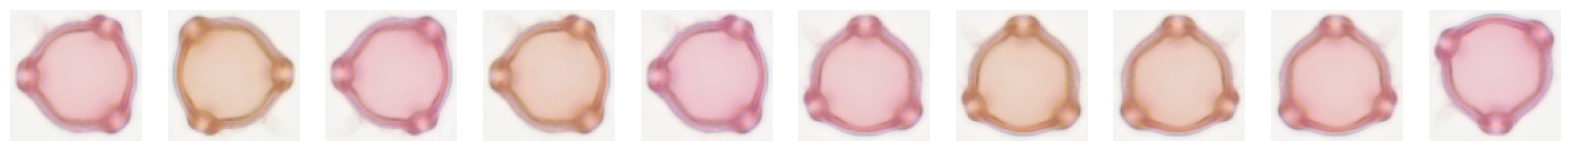

In [17]:
random.seed(seed)

plt.figure(figsize=(20,20))
sample_img = np.asarray(cv2.cvtColor(cv2.imread(files["SAMPLE_AUGMENTATION"]), cv2.COLOR_BGR2RGB))


for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    augmented_image = expand_data(sample_img, 0.3, height_factor= (0, 0.3), width_factor= (0, 0.3))
    plt.imshow(augmented_image.astype(np.uint8))
    plt.axis("off")

### 3.2. Data Augmentation - Training and Validation
We will extend the dataset by applying data augmentation to the remainder of the images. For comparance we used the same techniques as presented by (...) except for ... since we found that this technique does not reflect the variation in our data. Hence we replaced this technique with ... . Also we referred from rotating the images by increments of 90 degrees and instead used random rotations around -10 ord +10 degrees. 

In [22]:

def augment_data(input, lower_saturation :float , upper_saturation: float, max_sharpness : float, sigma : float):
    """This function returns 5 augmented versions of an input image using random saturation, sharpness, gaussian blur, guassian noise and image dehazing.
    
    input:              np.ndarray  should be in format (x,y,3)
    lower_saturation:   float       lower end of saturation shift
    upper_saturation:   float       upper end of saturation shift
    max_sharpness:      float       strength of artificial sharpening
    sigma:              float       intensitiy of gaussian blur
    """
    
    #tf.keras.backend.clear_session() #augmentation like this on different size input poses issues for retracing.You can also rescale all images to 140x140x3 first before augmentation.

    # Augment image by changing saturation.
    aug1 = rotate(input, angles= random.uniform(-0.3, 0.3), interpolation= "bilinear", fill_mode= 'reflect')
    aug1 = random_hsv_in_yiq(aug1,lower_saturation = lower_saturation, upper_saturation = upper_saturation)
    aug1 = random_flip(aug1)

    # Augment image by sharpening contours
    aug2 = rotate(input, angles= random.uniform(-0.3, 0.3), interpolation= "bilinear", fill_mode= 'reflect')
    aug2 = sharpness(aug2, factor = random.uniform(1.0, max_sharpness))
    aug2 = random_flip(aug2)

    # Augment image by applying a Gaussian Blur Kernel.
    aug3 = rotate(input, angles= random.uniform(-0.3, 0.3), interpolation= "bilinear", fill_mode= 'reflect')
    aug3 = gaussian_filter2d(aug3, filter_shape = (5,5), sigma = sigma)
    aug3 = random_flip(aug3)

    # Augment image by reducing the haze in the image.
    aug4 = rotate(input, angles= random.uniform(-0.1, 0.1), interpolation= "bilinear", fill_mode= 'reflect')
    aug4 = image_dehazer.remove_haze(np.asarray(aug4), delta= random.uniform(0.1, 0.5), showHazeTransmissionMap=False)[0]
    aug4 = random_flip(aug4)

    # Augment image by adding Gaussian Noise.
    gauss_noise=np.zeros(np.shape(input),dtype=np.uint8)
    cv2.randn(gauss_noise,0,40)
    gauss_noise=(gauss_noise*0.5).astype(np.uint8)

    aug5 = np.asarray(rotate(input, angles= random.uniform(-0.3, 0.3), interpolation= "bilinear", fill_mode= 'reflect', fill_value= 255))
    aug5 = cv2.add(aug5, gauss_noise)
    aug5 = random_flip(aug5)

    return [aug1, aug2, aug3, aug4, aug5]
    

In [7]:
random.seed(seed)

plt.figure(figsize=(10,10))
sample_img = np.asarray(cv2.cvtColor(cv2.imread(files["SAMPLE_AUGMENTATION"]), cv2.COLOR_BGR2RGB))


augmented_images = augment_data(sample_img, 
                                lower_saturation= 0.6, 
                                upper_saturation = 1.3, 
                                max_sharpness= 10, 
                                sigma = 100.0)


for index, i in enumerate(augmented_images):
    
    ax = plt.subplot(1, 5, index + 1)
    plt.imshow(random_flip(i))
    plt.axis("off")
    

: 

## Classification - Model

The model consists uses a Transfer Learning approach, which is favourable for the small data size in this experiment. We employ a predifined CNN Architecture as feature extractor with weights that are trained on the imagenet dataset. We then add a Top Layer consisting of two Hidden Layers and one Output Layer. 

In [4]:
categories = ["APIACEAE", "ARTEMISIA", "ARTEMISIA_SIDE", "BETULA", "BETULA_SIDE","CHENOPODIACEAE", 
              "CYPERACEAE", "HELIANTHEMUM","LYCOPODIUM", "LYCOPODIUM_HALF", "NPP_CLASS1", "NPP_CLASS2", 
              "NPP_CLASS3", "NPP_CLASS4", "PINUS_WING", "POACEAE", "POACEAE_SIDE", "SALIX"]

In [5]:
img_width, img_height = cnnInputSize

def create_model():

    feature_extractor = keras.applications.xception.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        include_top=False,
        input_shape = (img_width,img_height,3),
    ) 


    feature_extractor.trainable = False

    input = feature_extractor.output
    x = keras.layers.GlobalAveragePooling2D()(input)
    x = keras.layers.Dense(200)(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(len(categories))(x)
    output = keras.layers.Softmax()(x)


    model = keras.models.Model(inputs = feature_extractor.input, outputs = output)


    #model.summary()

    return model

In [7]:
model = create_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 140, 140, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 69, 69, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 69, 69, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

### Training - Top Layer only!
This time we only train the top layer of the model and set the feature extractor as untrainable. 

In [8]:

if not os.path.exists(folders["CNN_MODEL"]):
    os.makedirs(folders["CNN_LOGS"])
    os.makedirs(folders["CNN_WEIGHTS"])

model = create_model()
normalization_layer = keras.layers.Rescaling(scale = 1./127.5, offset = -1) # normalizes all pixel values between [-1,1]

# Save initial model weights:
INIT_WEIGHTS = os.path.join(folders["CNN_WEIGHTS"], "init_weights.h5")
model.save_weights(INIT_WEIGHTS, overwrite= True)


for split in os.listdir(folders["CNN_TRAINING_SPLITS"]):

    # Load initial model weights to restore the process after training of each split
    model.load_weights(INIT_WEIGHTS)

    # Load the training split of fold x
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(folders["CNN_TRAINING_SPLITS"], split, "train"),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation = "gaussian")

    # preprocess the images using normalization -> all pixel values between [-1,1]
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

    validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(folders["CNN_TRAINING_SPLITS"], split, "validation"),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation = "gaussian")

    validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate= learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["acc"],
    )

    MODEL_PATH = os.path.join(folders["CNN_WEIGHTS"], split + ".h5")
    LOG_PATH = os.path.join(folders["CNN_LOGS"], split)

    callbecks = [tf.keras.callbacks.TensorBoard(log_dir = LOG_PATH), 
                EarlyStopping(monitor ='val_loss', patience = 10, min_delta= 0.1),
                ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', mode='min')]
    
    # Train model for the current split
    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=validation_ds,
                        callbacks= callbecks,
                        use_multiprocessing= True,
                        workers= 8,
                        )

Found 3019 files belonging to 18 classes.
Found 755 files belonging to 18 classes.
Epoch 1/150
95/95 [==============================] - 19s 117ms/step - loss: 2.3187 - acc: 0.3283 - val_loss: 1.5246 - val_acc: 0.6384
Epoch 2/150
95/95 [==============================] - 10s 100ms/step - loss: 1.2389 - acc: 0.6900 - val_loss: 0.9718 - val_acc: 0.7987
Epoch 3/150
95/95 [==============================] - 10s 105ms/step - loss: 0.8550 - acc: 0.7917 - val_loss: 0.7322 - val_acc: 0.8371
Epoch 4/150
95/95 [==============================] - 10s 106ms/step - loss: 0.6495 - acc: 0.8427 - val_loss: 0.5976 - val_acc: 0.8781
Epoch 5/150
95/95 [==============================] - 10s 106ms/step - loss: 0.5422 - acc: 0.8668 - val_loss: 0.5125 - val_acc: 0.8887
Epoch 6/150
95/95 [==============================] - 10s 107ms/step - loss: 0.4519 - acc: 0.8917 - val_loss: 0.4481 - val_acc: 0.9033
Epoch 7/150
95/95 [==============================] - 10s 107ms/step - loss: 0.3982 - acc: 0.9046 - val_loss: 0.40

# Fine - Tuning the top 100 Layers

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = '' # In case fine-tuning on GPU is too computationally expensive for your device, execute this line to execute traiing on CPU

In [12]:
import keras
epochs = 20
batch_size = 16
learning_rate = 0.0002
random.seed(seed)



for split in range(fold):

    #model = create_model()
    model.load_weights(os.path.join(folders["CNN_WEIGHTS"], "split_{}.h5".format(split)))

    for layer in model.layers[-100:]:
        ### Batch Nornmalization Layers should not be set to True.
        if layer.name.split("_")[-1] != "bn":
            layer.trainable = True


    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(folders["CNN_TRAINING_SPLITS"], "split_{}".format(split), "train"),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation = "gaussian")

    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

    validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(folders["CNN_TRAINING_SPLITS"], "split_{}".format(split), "validation"),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation = "gaussian")

    validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

    MODEL_PATH = os.path.join(folders["CNN_FINE_TUNE"], "fine_tuned_{}".format(split) + ".h5")

    model.compile(
        optimizer=keras.optimizers.adam_v2.Adam(learning_rate= learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["acc"],
    )

    callbecks = [tf.keras.callbacks.TensorBoard(log_dir = folders["CNN_LOGS"]), 
                ModelCheckpoint(folders["CNN_MODEL"], save_best_only=True, monitor='val_loss', mode='min')]

    # Train model for the current split
    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=validation_ds,
                        callbacks= callbecks,
                        use_multiprocessing= True,
                        workers= 4,
                        verbose = 1)

Found 3019 files belonging to 18 classes.
Found 755 files belonging to 18 classes.
Epoch 1/20
189/189 [==============================] - 35s 156ms/step - loss: 0.3661 - acc: 0.8837 - val_loss: 0.1448 - val_acc: 0.9430
Epoch 2/20
189/189 [==============================] - 32s 170ms/step - loss: 0.1007 - acc: 0.9636 - val_loss: 0.1169 - val_acc: 0.9589
Epoch 3/20
189/189 [==============================] - 35s 183ms/step - loss: 0.0850 - acc: 0.9748 - val_loss: 0.0671 - val_acc: 0.9722
Epoch 4/20
189/189 [==============================] - 22s 117ms/step - loss: 0.0428 - acc: 0.9844 - val_loss: 0.1658 - val_acc: 0.9563
Epoch 5/20
189/189 [==============================] - 22s 118ms/step - loss: 0.0605 - acc: 0.9854 - val_loss: 0.1411 - val_acc: 0.9735
Epoch 6/20
189/189 [==============================] - 32s 169ms/step - loss: 0.0134 - acc: 0.9974 - val_loss: 0.0236 - val_acc: 0.9894
Epoch 7/20
189/189 [==============================] - 22s 113ms/step - loss: 0.0645 - acc: 0.9864 - val_los

### Validation - Wrong Classifications in test set.

In [7]:
model = create_model()
model.load_weights(os.path.join(folders["CNN_FINE_TUNE"], "fine_tuned_0.h5"))
model.trainable = False
normalization_layer = keras.layers.Rescaling(scale = 1./127.5, offset = -1)

In [8]:
### Setup Model:
#if model != None:
    #del model
model = create_model()
model.load_weights(os.path.join(folders["CNN_FINE_TUNE"], "fine_tuned_0.h5"))
model.trainable = False
normalization_layer = keras.layers.Rescaling(scale = 1./127.5, offset = -1)

#### Load Test-Data
test_ds = tf.keras.utils.image_dataset_from_directory(
    folders["CNN_EVALUATION_1"],
    image_size=(img_height, img_width),
    batch_size = 1,
    interpolation = "gaussian"
)

labels = []
images = []
ori_images = []

evaluation = {}

for x,y in test_ds:
    labels.append(y)
    ori_images.append(x)
    images.append(normalization_layer(x)) 

labels = np.array(labels)

Found 198 files belonging to 18 classes.


In [9]:
model.load_weights(os.path.join(folders["CNN_FINE_TUNE"], "fine_tuned_0.h5"))

In [10]:

CNN_WRONG_CLASSIFIED = os.path.join("model", "logs", "wrong_classified")

class_predictions = [model.predict(x) for x in images]


for index, prediction in enumerate(class_predictions):
    prediction = prediction[0]
    label = labels[index][0]

    prediction_label = categories[np.argmax(prediction)].split("_")[0]
    true_label = categories[label].split("_")[0]

    if true_label not in evaluation.keys():
        evaluation[true_label] = {"TP" : 0, "FP" : 0, "FN": 0}

    if prediction_label not in evaluation.keys():
        evaluation[prediction_label] = {"TP" : 0, "FP" : 0, "FN": 0}


    if true_label != prediction_label:
        print("Wrong classified: \n \t predicted value: {} with {:.2f} % \n \t true value: {} with {:.2f} %".format(prediction_label, np.max(prediction)*100, true_label, prediction[label] * 100))

        cv2.imwrite(os.path.join(CNN_WRONG_CLASSIFIED, "{}_{}_{}_{}.png".format(index, true_label, prediction_label, int(np.max(prediction)*100))), cv2.cvtColor(np.array(ori_images[index][0]), cv2.COLOR_RGB2BGR))
        evaluation[true_label]["FN"] = evaluation[true_label]["FN"] + 1
        evaluation[prediction_label]["FP"] = evaluation[prediction_label]["FP"] + 1

    else:
        evaluation[true_label]["TP"] = evaluation[true_label]["TP"] + 1

MSR = []
MSP = []
MSF1 = []
MSA = []
keys = list(evaluation.keys())
keys.sort()
for pollen in keys:
    if pollen != "NPP":
        TP = evaluation[pollen]["TP"]
        FP = evaluation[pollen]["FP"]
        FN = evaluation[pollen]["FN"]
        TN = len(images) - FP
        Recall = TP/(TP+FP)
        Precision = TP/(TP+FN)
        F1 = ((Recall * Precision) / (Recall + Precision))*2
        Accuracy = (TP+TN)/(TP+TN+FP+FN)
        MSR.append(Recall)
        MSP.append(Precision)
        MSF1.append(F1)
        MSA.append(Accuracy)
        print(pollen, "\n\tRecall:\t\t", str(Recall), "\n\tPrecision:\t", str(Precision), "\n\tF1-Score:\t", str(F1), "\n\tAccuracy\t", str(F1))

print("Mean Recall\t:", np.mean(MSR), "\tMean Precision:\t" , np.mean(MSP), "\tMean F1-Score\t", np.mean(MSF1), "\tMean Accuracy\t", np.mean(MSA))



APIACEAE 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
ARTEMISIA 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
BETULA 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
CHENOPODIACEAE 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
CYPERACEAE 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
HELIANTHEMUM 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
LYCOPODIUM 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
PINUS 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
POACEAE 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
SALIX 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
Mean Recall	: 1.0 	Mean Precision:	 1.0 	Mean F1-Score	 1.0 	Mean Accuracy	 1.0


### Visualization of Model Function
We use the Grad Cam and Occlusion Sensitivity procedure to visualize, how the feature extractor is performing on pollen images and to possibly detect pollen that pose certain issues on the classification. Fran°ois Chollet 

In [10]:
normalization_layer = keras.layers.Rescaling(scale = 1./127.5, offset = -1)

Predicted: ('APIACEAE', 0.99999917)


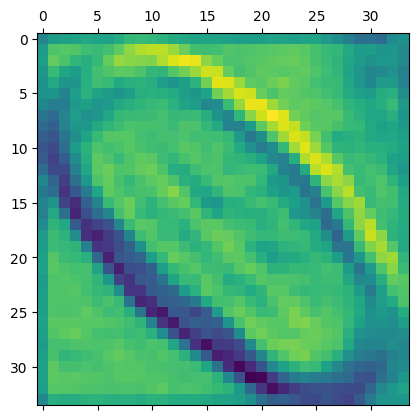

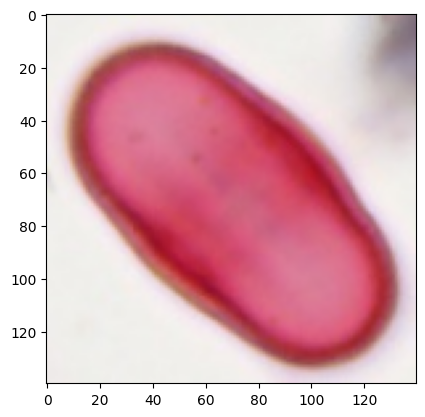

In [11]:
# Prepare image
img = np.asarray(cv2.resize(cv2.cvtColor(cv2.imread(files["SAMPLE_GRAD_CAM"]), cv2.COLOR_BGR2RGB ), dsize=(140,140)))
img_array = normalization_layer([img])

last_conv_layer_name = "block3_sepconv1"

def decode_predictions(preds, top = 5):
    decoded = []
    for i in range(0,top):
        index = np.argmax(preds)
        decoded.append((categories[index], np.max(preds)))
        preds[index] = 0.0

    return decoded

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds[0], top=1)[0])

# Generate class activation heatmap
heatmap = code_snypets.make_gradcam_heatmap(img_array, model, last_conv_layer_name)



# Display heatmap
plt.matshow(heatmap)
plt.show()
plt.imshow(img)
plt.show()

True Label: images\EXPERIMENTS\EXPERIMENT_1\APIACEAE
Predicted: ('APIACEAE', 1.0)


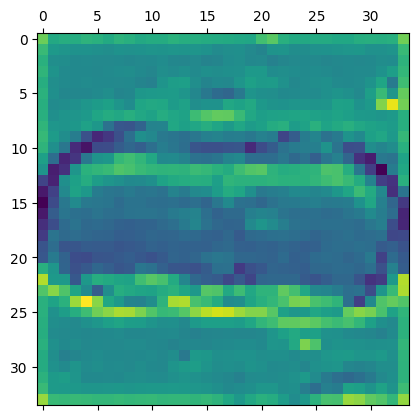

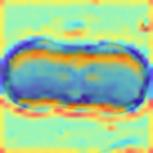

True Label: images\EXPERIMENTS\EXPERIMENT_1\ARTEMISIA
Predicted: ('ARTEMISIA_SIDE', 0.9999994)


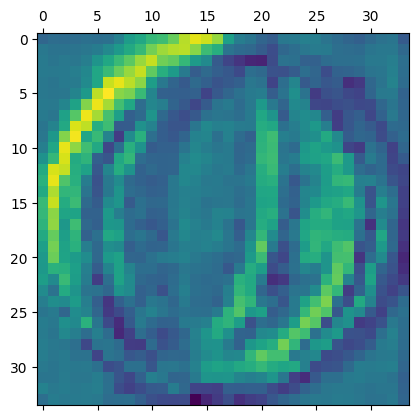

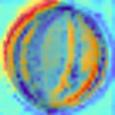

True Label: images\EXPERIMENTS\EXPERIMENT_1\BETULA
Predicted: ('BETULA', 1.0)


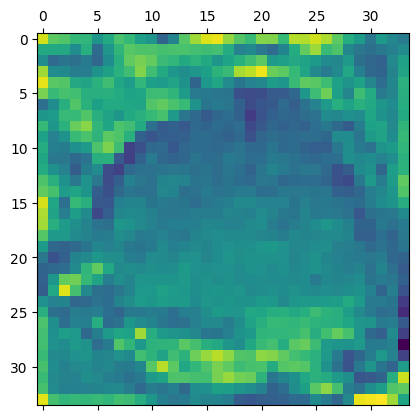

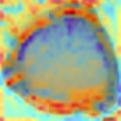

True Label: images\EXPERIMENTS\EXPERIMENT_1\CHENOPODIACEAE
Predicted: ('CHENOPODIACEAE', 1.0)


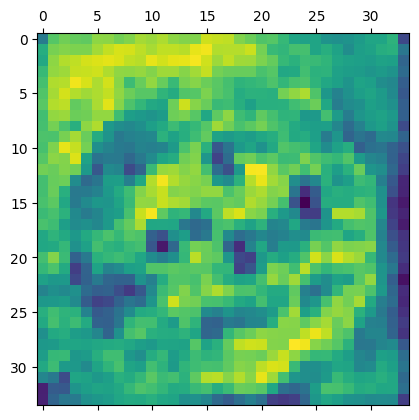

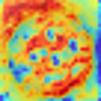

True Label: images\EXPERIMENTS\EXPERIMENT_1\CYPERACEAE
Predicted: ('CYPERACEAE', 1.0)


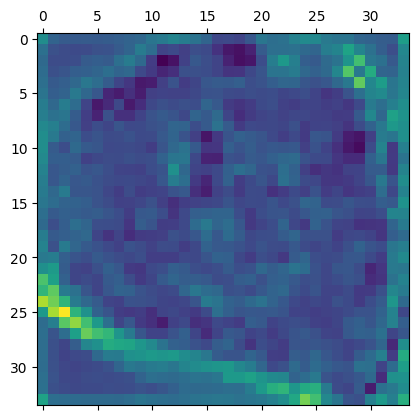

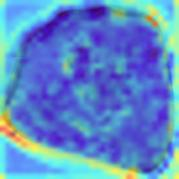

True Label: images\EXPERIMENTS\EXPERIMENT_1\HELIANTHEMUM
Predicted: ('HELIANTHEMUM', 1.0)


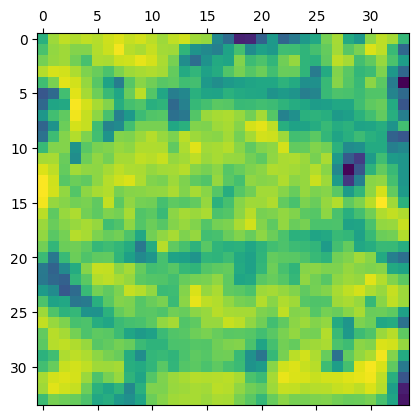

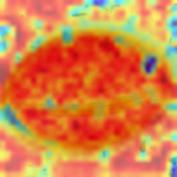

True Label: images\EXPERIMENTS\EXPERIMENT_1\LYCOPODIUM
Predicted: ('LYCOPODIUM', 1.0)


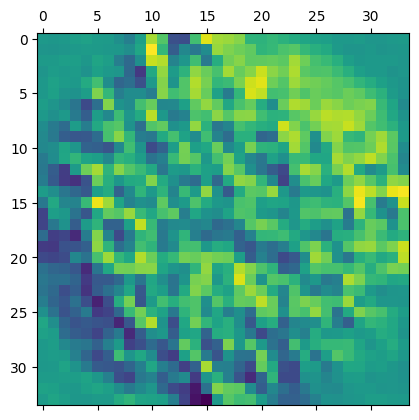

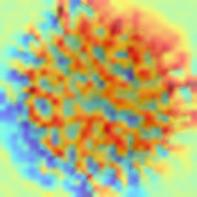

True Label: images\EXPERIMENTS\EXPERIMENT_1\PINUS_WING
Predicted: ('PINUS_WING', 1.0)


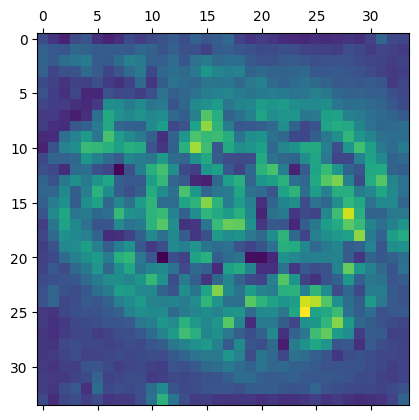

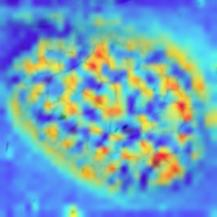

True Label: images\EXPERIMENTS\EXPERIMENT_1\POACEAE
Predicted: ('POACEAE_SIDE', 0.9998247)


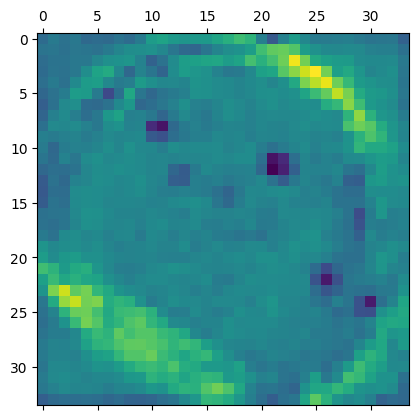

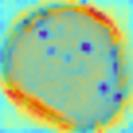

True Label: images\EXPERIMENTS\EXPERIMENT_1\SALIX
Predicted: ('SALIX', 1.0)


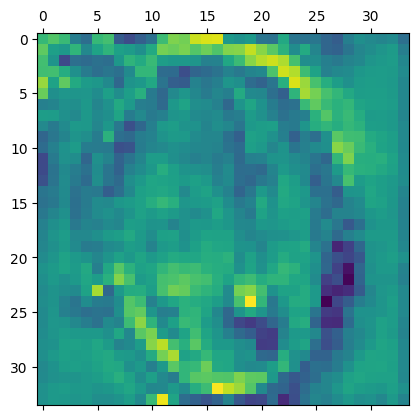

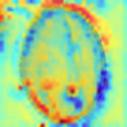

In [12]:
random.seed(seed)

for index, subdir in enumerate(os.listdir(folders["CNN_EVALUATION_1"])):
    SUB_PATH = os.path.join(folders["CNN_EVALUATION_1"], subdir)
    if len (os.listdir(SUB_PATH)) == 0:
        continue
    IMG_PATH = os.path.join(SUB_PATH, random.choice(os.listdir(SUB_PATH)))

    # Prepare image
    img_array = normalization_layer(code_snypets.get_img_array(IMG_PATH, size= (140,140)))

    last_conv_layer_name = "block3_sepconv1_act"

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    print("True Label:", SUB_PATH)
    print("Predicted:", decode_predictions(preds[0], top=1)[0])

    # Generate class activation heatmap
    heatmap = code_snypets.make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = index)
    # Display heatmap
    plt.matshow(heatmap)
    plt.show()
    SAVE_PATH = os.path.join(folders["VISUALIZATION_PATH"], last_conv_layer_name, "GCAM_{}_{}.jpg".format(last_conv_layer_name, subdir))
    if not os.path.exists(os.path.dirname(SAVE_PATH)):
        os.makedirs(os.path.dirname(SAVE_PATH))
    code_snypets.save_and_display_gradcam(IMG_PATH, heatmap, cam_path= SAVE_PATH)


In [13]:
import keras
from tf_explain.callbacks.grad_cam import GradCAMCallback
from tf_explain.callbacks.occlusion_sensitivity import OcclusionSensitivityCallback
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback

model = create_model()
model.trainable = False
model.load_weights(os.path.join(folders["CNN_FINE_TUNE"], "fine_tuned_0.h5"))
epochs = 1
batch_size = 32
learning_rate = 0
random.seed(seed)


VISUALIZATION_PATH = os.path.join("visuals", "CNN_TOP_LAYER_ONLY")
if not os.path.exists(VISUALIZATION_PATH):
    os.makedirs(VISUALIZATION_PATH)

model.trainable = False


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
os.path.join(folders["CNN_TRAINING_SPLITS"], "split_0", "train"),
image_size=(img_height, img_width),
batch_size=batch_size,
interpolation = "gaussian")

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
os.path.join(folders["CNN_TRAINING_SPLITS"], "split_0", "validation"),
image_size=(img_height, img_width),
batch_size=batch_size,
interpolation = "gaussian")

validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

images = []
labels =[]

for idx, subdir in enumerate(os.listdir(folders["CNN_EVALUATION_1"])):
    SUB_PATH = os.path.join(folders["CNN_EVALUATION_1"], subdir)

    try:
        img = cv2.imread(os.path.join(SUB_PATH, random.choice(os.listdir(SUB_PATH))))
    except:
        continue
    img = cv2.resize(img, dsize= (140,140))
    img = np.asarray(img)
    images.append(normalization_layer(img))
    labels.append(idx)

images = np.asarray(images)
labels = np.asarray(labels)

callbecks = [OcclusionSensitivityCallback(validation_data= (images,labels), class_index= 8, patch_size= 18, output_dir= VISUALIZATION_PATH)]

model.compile(
    optimizer=keras.optimizers.adam_v2.Adam(learning_rate= learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
)

# Train model for the current split
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=validation_ds,
                    callbacks= callbecks,
                    use_multiprocessing= False,

                    )

Found 3019 files belonging to 18 classes.
Found 755 files belonging to 18 classes.
95/95 [==============================] - 21s 178ms/step - loss: 1.6470e-06 - acc: 1.0000 - val_loss: 0.0092 - val_acc: 0.9947


## Data Augmentation for Semantic Segmentation.
As for Classification, we will expand and augment our dataset for training the segmentation model as well. For this we make use of the package Albumentations which helps with the transformation of bounding box coordinates for transformations that involve rotations, flipping, cropping or zooming.

### Expand Database for Chenopodiaceae and Helianthemum

(-0.5, 1199.5, 1199.5, -0.5)

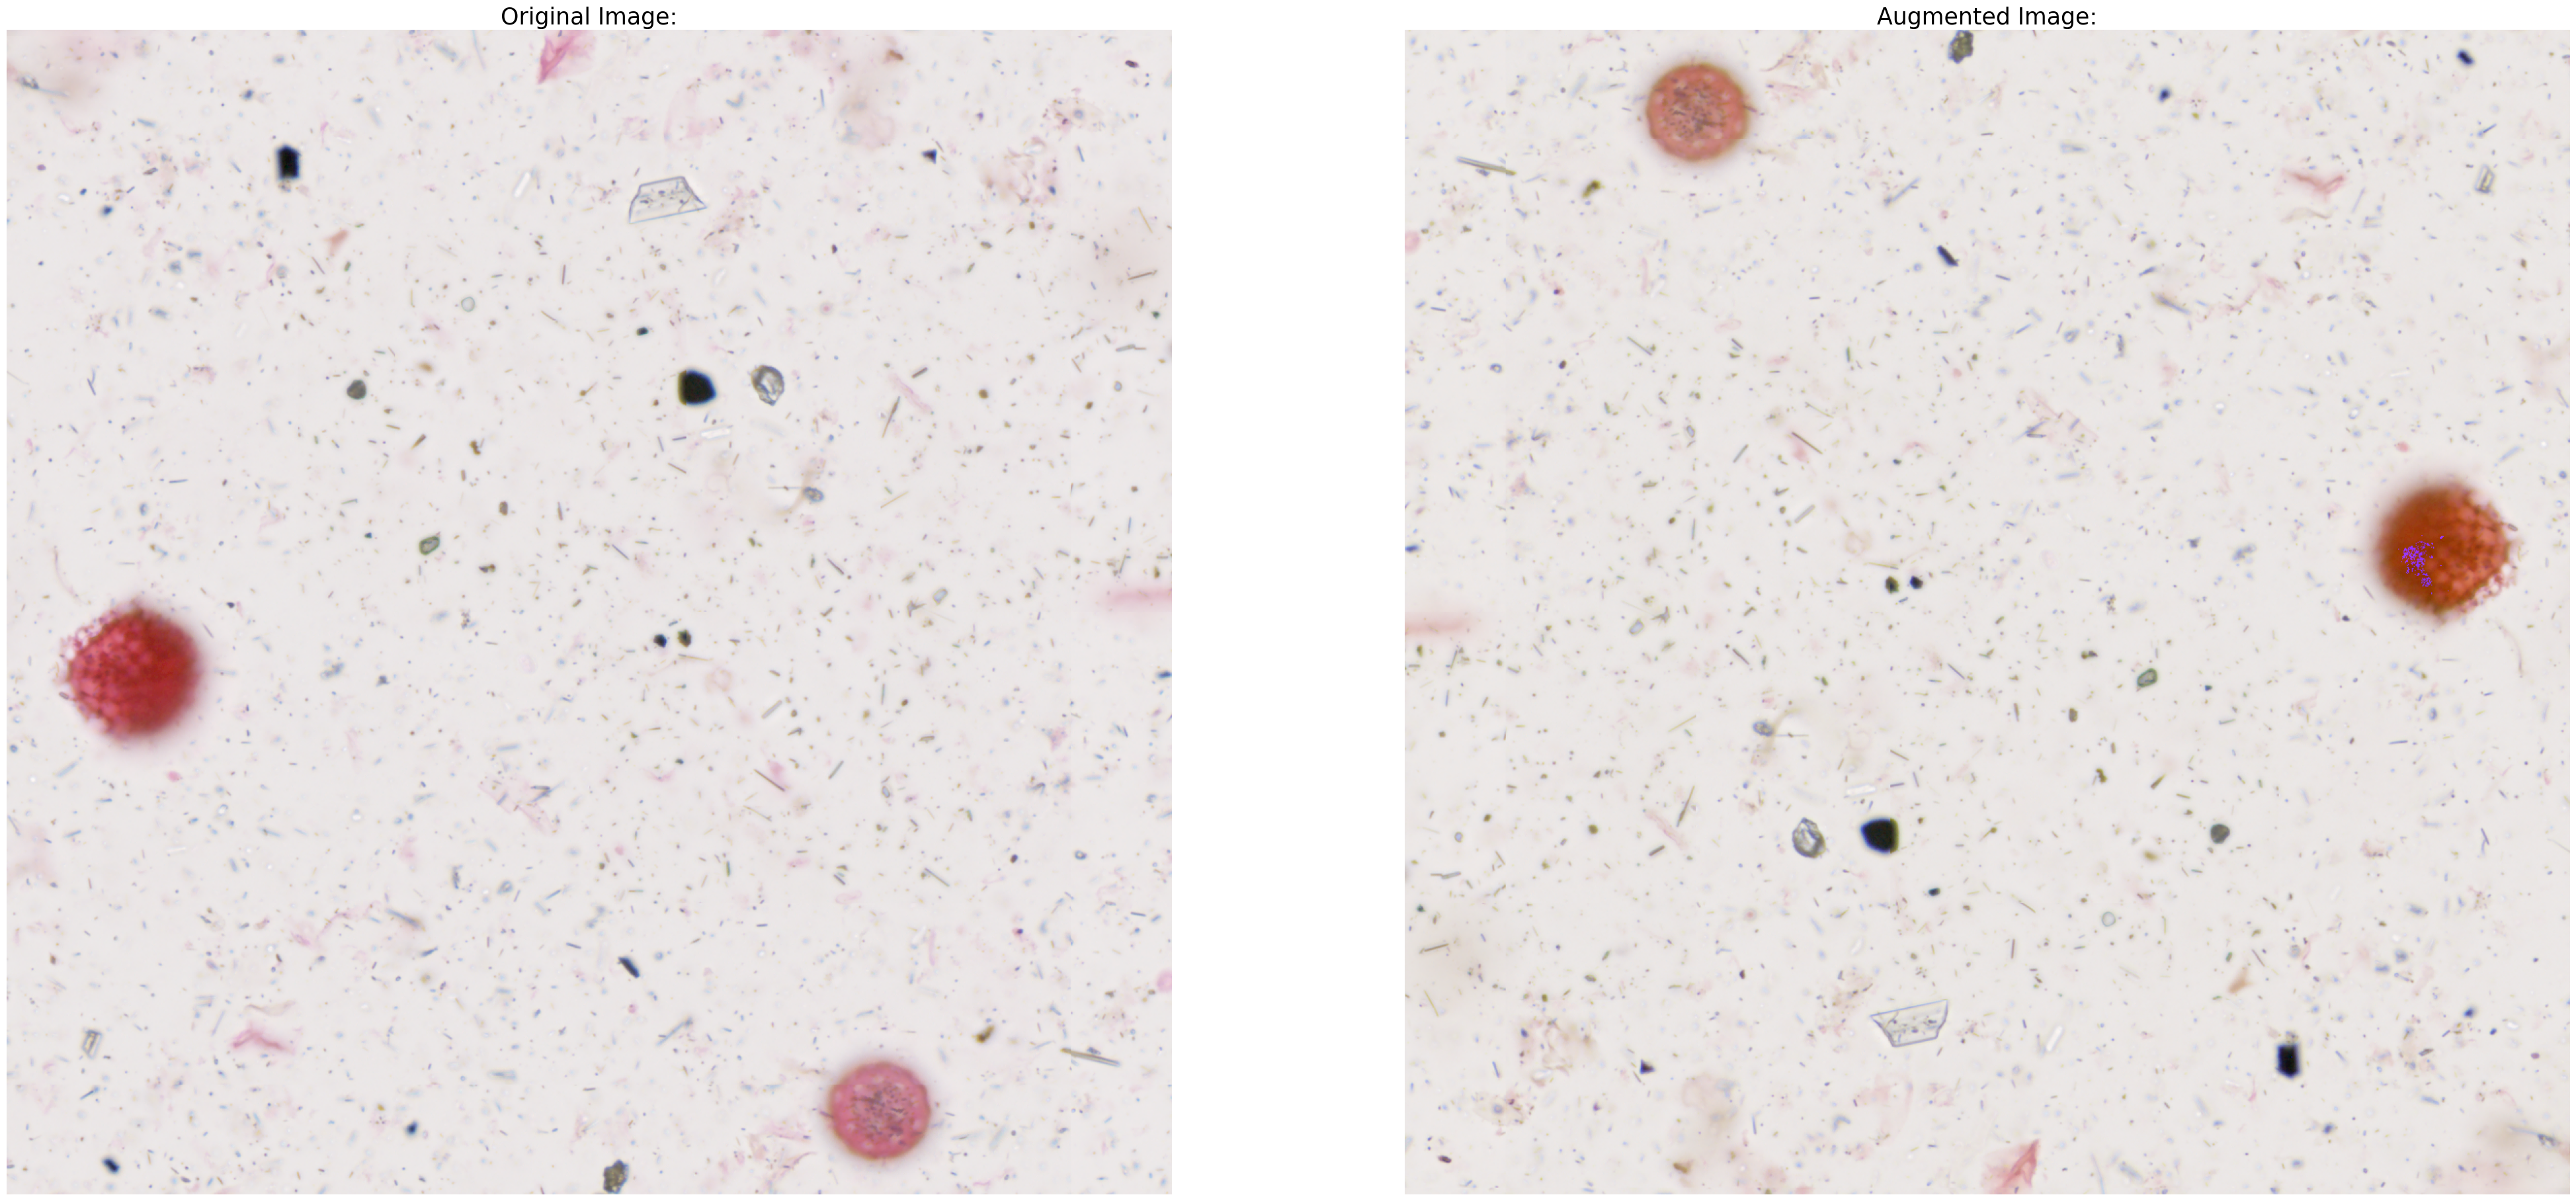

In [19]:

random.seed(seed)

plt.figure(figsize=(50,50))
sample_image = np.asarray(cv2.cvtColor(cv2.imread(files["SAMPLE_SEGMENTATION_IMG"]), cv2.COLOR_BGR2RGB))

ax = plt.subplot(1, 2, 1)
ax.title.set_text("Original Image:")
ax.title.set_size(25)
plt.imshow(random_flip(sample_image))
plt.axis("off")


ax = plt.subplot(1, 2, 2)
ax.title.set_text("Augmented Image:")
ax.title.set_size(25)
augmented_image = expand_data(sample_image, 0.5, height_factor= (0, 0.3), width_factor= (0, 0.3))
plt.imshow(augmented_image.astype(np.uint8))
plt.axis("off")


### Data Augmentation for expanding the whole Database 5-fold

In [23]:
SAMPLE_SEGMENTATION_PATH = os.path.join(files["SAMPLE_SEGMENTATION_IMG"])
SAMPLE_SEGMENTATION_PATH_XML = os.path.join(files["SAMPLE_SEGMENTATION_XML"])
random.seed(seed)

plt.figure(figsize=(25,25))
sample_image = np.asarray(cv2.cvtColor(cv2.imread(SAMPLE_SEGMENTATION_PATH), cv2.COLOR_BGR2RGB))


augmented_images = augment_data(sample_image, 
                                lower_saturation= 0.6, 
                                upper_saturation = 1.3, 
                                max_sharpness= 10, 
                                sigma = 100.0)


for index, i in enumerate(augmented_images):
    ax = plt.subplot(1, 5, index + 1)
    plt.imshow(random_flip(i))
    plt.axis("off")
    


: 

### Training and Evaluation

For Resource purposes we employed our training on paperspace.com using and modifying the code writen in GitHub-Link

### Using Object Detection to detect pollen grains.

Here you can test the whole pipeline together by changing the INPUT_PATH variable. This Github repository provides you with some example imags to see, whether the setup works. Please note that the code will only work for pollen this model was trained on. It may detect other pollen as well, but it won't correctly classify them, as it has no previous knowledge about these new pollen.


In [6]:
INPUT_PATH = os.path.join("samples", "OD_TEST")
OUTPUT_PATH = os.path.join("samples", "OD_OUTPUT")

In [7]:
from object_detection.builders import model_builder
from object_detection.utils import config_util


PIPELINE_CONFIG = os.path.join("model", "OBJECT_DETECTION_MODEL", "CENTERNETHG104_FINAL", "pipeline.config")
CHKPT_PATH = os.path.join("model",  "OBJECT_DETECTION_MODEL", "CENTERNETHG104_FINAL", "ckpt-9")

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(CHKPT_PATH).expect_partial()

In [8]:
CNN_PATH = os.path.join(folders["CNN_FINE_TUNE"], "fine_tuned_0.h5")
categories = ["APIACEAE", "ARTEMISIA", "ARTEMISIA_SIDE", "BETULA", "BETULA_SIDE","CHENOPODIACEAE", "CYPERACEAE", "HELIANTHEMUM",
              "LYCOPODIUM", "LYCOPODIUM_HALF", "PINUS_WING", "POACEAE", "POACEAE_SIDE", "SALIX","NPP_CLASS1", "NPP_CLASS2", "NPP_CLASS3", "NPP_CLASS4"]

count_classes = ["APIACEAE", "ARTEMISIA", "BETULA", "CHENOPODIACEAE", "CYPERACEAE", "HELIANTHEMUM", "PINUS", "POACEAE", "SALIX","OTHERS", "LYCOPODIUM", "OFP"]

model = create_model()
model.trainable = False
model.load_weights(CNN_PATH)

## These are the thresholds per class that were experimentally determined. You may change them to see, how this influences the pipeline's output.
class_th = [0.4, 0.45, 0.45, 0.6, 0.6, 0.7, 0.55, 0.3, 0.6, 0.45, 0.75, 0.6, 0.6, 0.8, 0.9, 0.9, 0.9, 0.9]

try:
    with open(os.path.join("DB_1.csv"), "w", newline="") as outputfile:
        outputfile.write(";".join(str(e) for e in count_classes)+"\n")

        for idx, subdir in enumerate(os.listdir(INPUT_PATH)):

            SUB_INPUT_PATH = os.path.join(INPUT_PATH, subdir)
            SUB_OUTPUT_PATH = os.path.join(OUTPUT_PATH, "DETECTION_{}".format(subdir.split("__")[1]))
            DB = code_snypets.count_pollen(SUB_INPUT_PATH, SUB_OUTPUT_PATH, cnn_model = model, detection_model= detection_model, threshold= class_th, seg_threshold= 0.2,categories= categories, inspect_boxes= True)

            outputfile.write(";".join(str(DB[key]) for key in count_classes))
            outputfile.write("\n")

except KeyboardInterrupt:
    print("Process was interrupted!")
finally:
    print("Core Analysis terminated")


Initialized automated Pollen Analysis on slide__001


100%|██████████| 18/18 [00:55<00:00,  3.09s/it]


Initialized automated Pollen Analysis on slide__002


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

Core Analysis terminated
